In [1]:
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

D:\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 12

In [3]:
img_rows, img_cols = 28, 28

In [4]:
# first downloads the data if it is not already downloaded
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
type(x_train)

numpy.ndarray

In [6]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [7]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [10]:
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

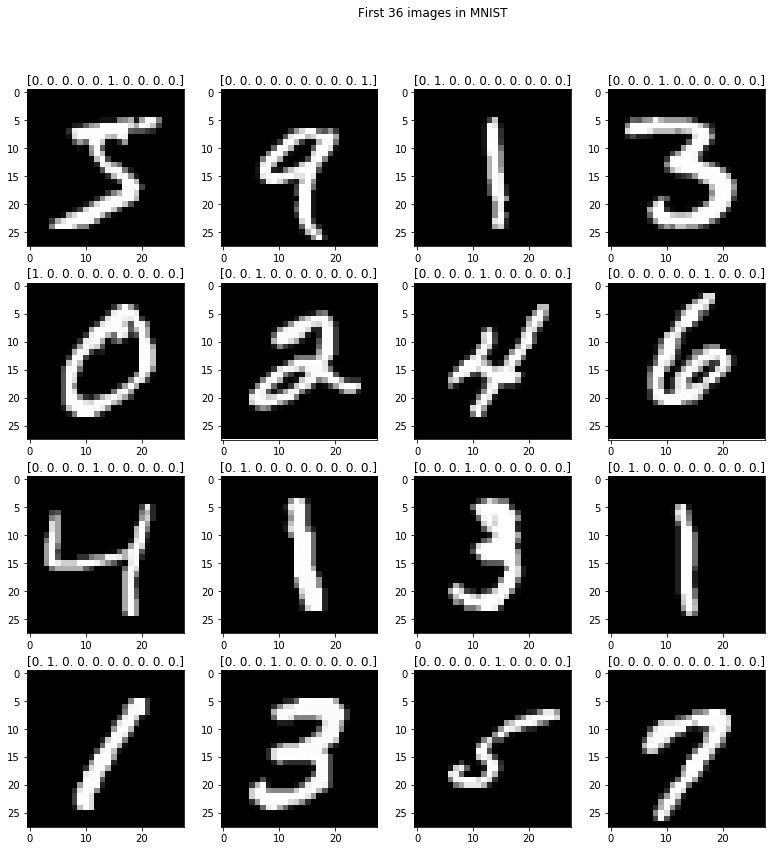

In [12]:
fig, ax = plt.subplots(4, 4, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(4) for j in range(4)]:
    ax[x, y].imshow(x_train[x + y * 4].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(y_train[x + y * 4])

In [13]:
#defining the model
model = Sequential()

In [14]:
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #only keep max value of 2x2 kernel
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [16]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
 5120/60000 [=>............................] - ETA: 1:27 - loss: 1.0788 - acc: 0.6477

KeyboardInterrupt: 

In [ ]:
# model = keras.models.load_model('mnist_model_keras_1.h5')

In [ ]:
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
def predict_and_show(num, num_images=1):
    fig, ax = plt.subplots(num_images, figsize = (12, 12))
    fig.tight_layout(h_pad = 4)
    for i in range(num_images):
        prediction = model.predict(x_test[num+i:num+i+1])
        predicted_number = np.argmax(prediction[0])
        if num_images == 1:
            ax.imshow(x_test[num+i].reshape((28, 28)), cmap='gray')
            ax.set_title("Predicted Number: {}\nCertainty: {}".format(predicted_number, prediction[0][predicted_number]))
        else:
            ax[i].imshow(x_test[num+i].reshape((28, 28)), cmap='gray')
            ax[i].set_title("Predicted Number: {}\nCertainty: {}".format(predicted_number, prediction[0][predicted_number]))
        

In [ ]:
predict_and_show(2346, num_images=4)

In [ ]:
# Visualizating filters

layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(model.summary())

In [ ]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

In [ ]:
vis_img_in_filter()

In [ ]:
vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_1')

In [ ]:
vis_img_in_filter(img = np.array(x_train[1]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_1')

In [ ]:
vis_img_in_filter(img = np.array(x_train[1]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2')